# Obtention des Données futures avec un Ridge 

## Prédiction du niveau de la nappe phréatique à partir des données 

Dans ce fichier, les données sont prédites à 7 jours (paramètre modifiable), avec une Ridge. 

In [3]:
from data_loading import load_X_Y, plot_results
import numpy as np 
import matplotlib.pyplot as plt 
dpath = '../../dataset/preprocessed/' # remplacer par le chemin d'accès vers les données. 
# NOTE: Prendre un fichier qui a été préalablement obtenu par DataPreprocessing.   
file_name = 'A146020302.csv'

In [4]:
from reservoirpy.datasets import to_forecasting
def normalize_data(data):
    # Normalizing data between 0 and 1 column by column
    min_vals = data.min(axis=0)
    max_vals = data.max(axis=0)
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data, min_vals, max_vals

data = load_X_Y(dpath + file_name)
data, min_vals, max_vals = normalize_data(data)
forecast = 7
x,y= to_forecasting(data[3156:], forecast=forecast)
y = y[:, -1].reshape(-1, 1) 
units = 1500 
leak_rate = 0.7503908723453986
spectral_radius = 0.12438215679394352
input_scaling = .7
connectivity = 0.6
input_connectivity = 0.3
regularization = 1e-1
seed = 42
X_train1, y_train1 = x[:2000], y[:2000]
X_test1, y_test1 = x[2000:], y[2000:]
X_test1 = np.asarray(X_test1) 
X_test1 = X_test1.reshape(X_test1.shape[0], -1) 


Les valeurs ci-dessus peuvent être optimisés suivant les cas dans le fichier hyperopt_multi_input_scaling.

In [5]:
from reservoirpy.nodes import Ridge
from reservoirpy.nodes import Reservoir 
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = Ridge(9.102910091122064)


esn_online = reservoir >> readout

In [6]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(ridge=regularization, output_dim=1) #10 size of the entry vector 

    return reservoir >> readout


In [7]:

from reservoirpy.nodes import Reservoir, Ridge
reset_esn()

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = Ridge(ridge=regularization, output_dim=1)

esn = reservoir >> readout


In [8]:
esn = esn.fit(X_train1, y_train1) # entrainement des données 
y_pred1 = esn.run(X_test1) # test avec le modèle 



Affichage des résultats sur des segments de données de taille  200


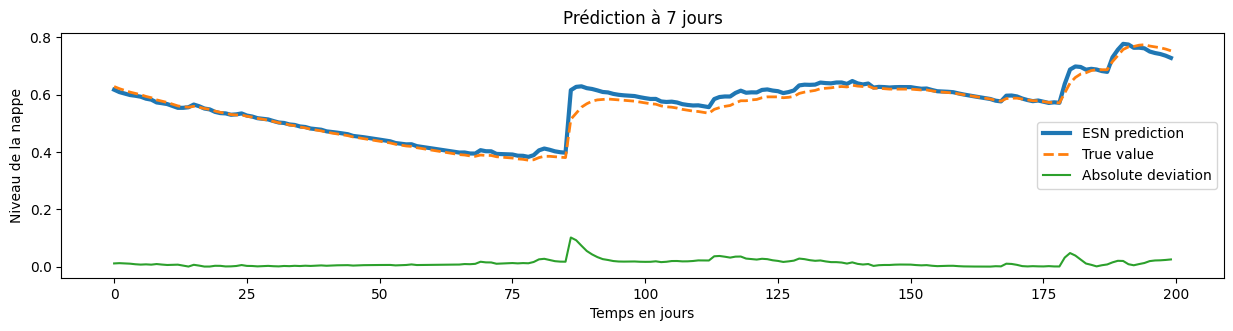

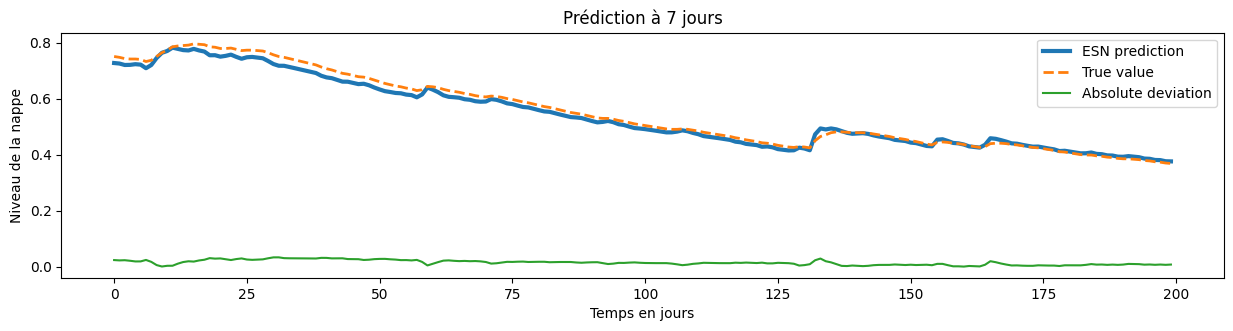

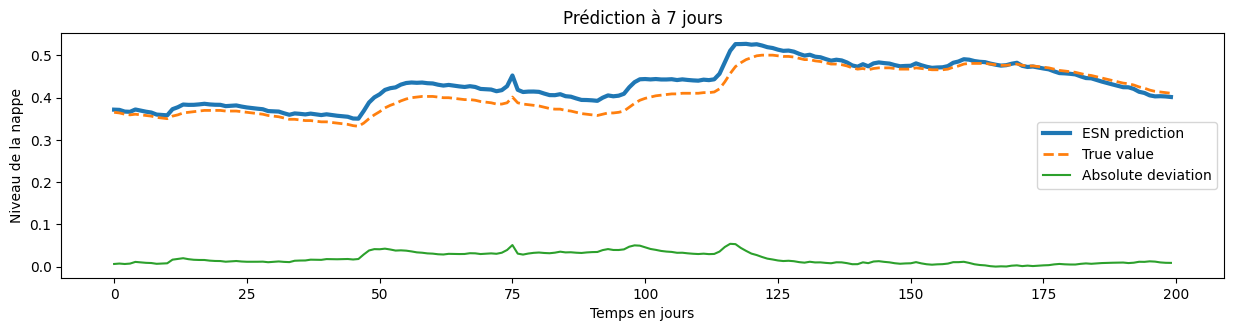

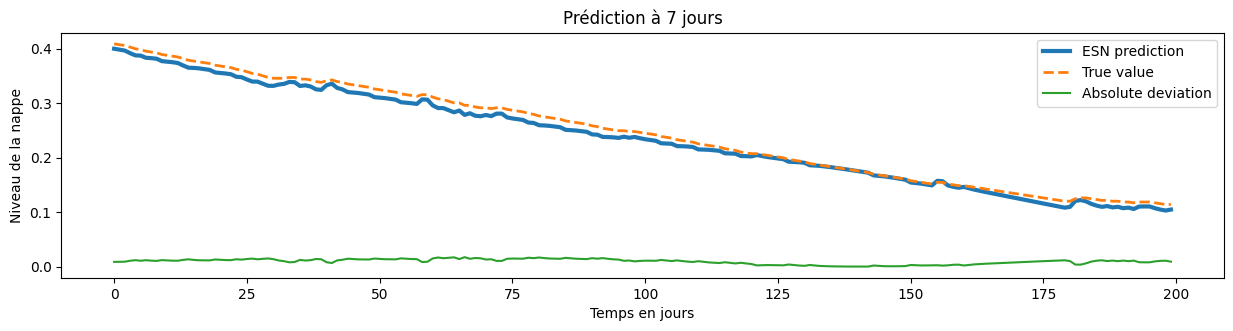



Affichage des résultats sur l'ensemble des segments


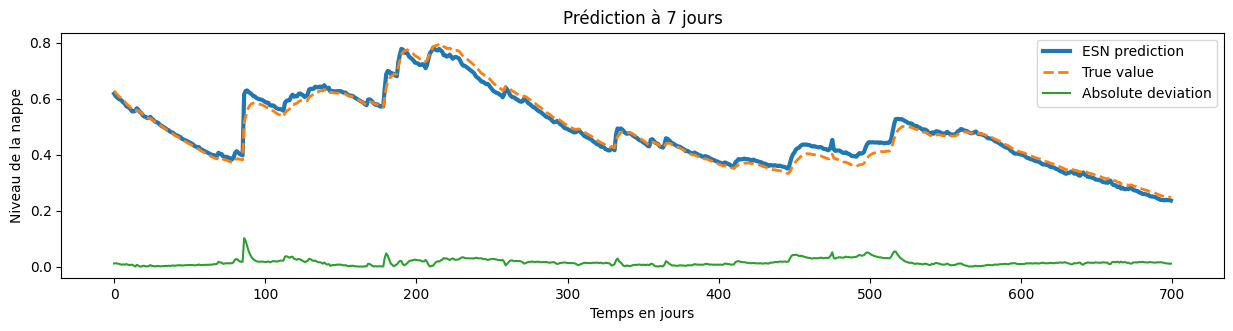

In [11]:
_from = 100
_to = 800
step = 200

print("\n\nAffichage des résultats sur des segments de données de taille ", step)
for i in range(_from, _to, step):
    plot_results(y_pred1[i+forecast:], y_test1[i:], forecast, sample=step, diff=True)

print("\n\nAffichage des résultats sur l'ensemble des segments")
plot_results(y_pred1[_from + forecast:],y_test1[_from:], forecast=forecast, sample=_to - _from, diff=True)